![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

## Destination Earth - Weather-Induced Extremes Digital Twin - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Documentation Digital Twin - Parameter Usage](https://confluence.ecmwf.int/display/DDCZ/DestinE+Parameter+Portfolios)

<br> Author: EUMETSAT </br>

Credit: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example.</br>

## Obtain Authentication Token

In [1]:
pip install --quiet --upgrade destinelab

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import ipywidgets as widgets
import json
import os
from getpass import getpass
import destinelab as deauth
from datetime import datetime, timedelta

First, we get an access token for the API

In [3]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


#### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [4]:
auth.is_DTaccess_allowed(access_token)

DT Output access allowed


True

## Query using the DEDL HDA API


### Filter
We have to setup up a filter and define which data to obtain.

Extreme DT data is available for specific time ranges (last 15 days) around the current date.

It is possible to use the ECMWF Aviso package to check data availability in the last 15 days (see the xtremeDT-dataAvailability notebook in this folder) and request data accordingly.


In [5]:
from datetime import datetime, timedelta

# Get the current date and time in UTC
current_date = datetime.utcnow()

# Calculate the date 15 days before the current date
date_15_days_ago = current_date - timedelta(days=15)

# Format the date as YYYYMMDD and set the time to 0000 UTC
formatted_date = date_15_days_ago.strftime('%Y%m%d') + '0000'
# Convert the formatted date back to a datetime object
date_from = datetime.strptime(formatted_date, '%Y%m%d%H%M%S').date()

# Format the date as YYYYMMDD and set the time to 0000 UTC
formatted_date = current_date.strftime('%Y%m%d') + '0000'
# Convert the formatted date back to a datetime object
date_to = datetime.strptime(formatted_date, '%Y%m%d%H%M%S').date()

In [6]:
start_date_picker = widgets.DatePicker(description='Start Date:', disabled=False)

# Set initial values directly
start_date_picker.min = date_from
start_date_picker.max = date_to
start_date_picker.value = date_to

def get_selected_values():
    selected_start_date = start_date_picker.value
    return selected_start_date

# Display widgets
display(start_date_picker)


DatePicker(value=datetime.date(2024, 12, 22), description='Start Date:', max=datetime.date(2024, 12, 22), min=…

In [7]:
# Example usage:
datechoice = get_selected_values().strftime("%Y-%m-%dT%H:%M:%SZ")
print(datechoice)
filters = {
    key: {"eq": value}
    for key, value in {
        "class": "d1",             # fixed (rd or d1)
        "dataset": "extremes-dt",  # fixed extreme dt 
        "expver": "0001",          # fixed experiment version 
        "stream": "oper",          # fixed oper
        "step": "0/6/12/18/24",    # Forcast step hourly (1..96)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "param": "151/228029"      # 10m Wind gust & Mean Sea Level Pressure
    }.items()
}

2024-12-16T00:00:00Z


## Make Data Request

In [8]:
#Sometimes requests to polytope get timeouts, it is then convenient define a retry strategy
retry_strategy = Retry(
    total=5,  # Total number of retries
    status_forcelist=[500, 502, 503, 504],  # List of 5xx status codes to retry on
    allowed_methods=["GET",'POST'],  # Methods to retry
    backoff_factor=1  # Wait time between retries (exponential backoff)
)

# Create an adapter with the retry strategy
adapter = HTTPAdapter(max_retries=retry_strategy)

# Create a session and mount the adapter
session = requests.Session()
session.mount("https://", adapter)

response = session.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.ECMWF.DAT.DT_EXTREMES"],
    "datetime": datechoice,
    "query": filters
})

# Requests to EO.ECMWF.DAT.DT_EXTREMES always return a single item containing all the requested data
if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

product = response.json()["features"][0]
product["id"]
#product

'DT_EXTREMES_20241216_20241216_abd8280032ee49084bef47c6fedffbc1c3ab2918'

## Submission worked ? Once our product found, we download the data.

In [9]:
from IPython.display import JSON

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]

HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = session.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
elif (response.status_code != HTTP_ACCEPTED_CODE):
    print(response.text)

response.raise_for_status()    
print(download_url)   

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_EXTREMES/items/DT_EXTREMES_20241216_20241216_abd8280032ee49084bef47c6fedffbc1c3ab2918/download?provider=dedt_lumi&_dc_qs=%257B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522extremes-dt%2522%252C%2B%2522date%2522%253A%2B%252220241216%252Fto%252F20241216%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522param%2522%253A%2B%2522151%252F228029%2522%252C%2B%2522step%2522%253A%2B%25220%252F6%252F12%252F18%252F24%2522%252C%2B%2522stream%2522%253A%2B%2522oper%2522%252C%2B%2522time%2522%253A%2B%25220%2522%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D


## Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

In [10]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        print(f"order status: {response.text}")
        response = session.get(url, headers=auth_headers, stream=True)
        
if (response.status_code not in (HTTP_SUCCESS_CODE,HTTP_ACCEPTED_CODE)):
    (print(response.text))

        
# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response)
    print(response.text)
    raise Exception("Headers: \n"+str(response.headers)+"\nContent-Disposition header not found in response. Must be something wrong.")
        
filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
order status: {"description":"Product is not available yet, please try again using given updated location","status":"queued","location":"https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_EXTREMES/items/DT_EXTREMES_20241216_20241216_abd8280032ee49084bef47c6fedffbc1c3ab2918/download?_dc_qs=%257B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522extremes-dt%2522%252C%2B%2522date%2522%253A%2B%252220241216%252Fto%252F20241216%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522param%2522%253A%2B%2522151%252F228029%2522%252C%2B%2522step%2522%253A%2B%25220%252F6%252F12%252F18%252F24%2522%252C%2B%2522stream%2522%253A%2B%2522oper%2522%252C%2B%2522time%2522%253A%2B%25220%2522%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D&message=Request+queued&status=queued&orderId=caadee7e-a2ac-4900-a961-059471734538&provider=dedt_lumi"}
order status: processing
order status: {"description":

100%|██████████| 532M/532M [00:25<00:00, 21.2MB/s] 


## Render the sea ice coverage on a map

Lets plot the result file

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [11]:
import earthkit.data
import earthkit.maps

data = earthkit.data.from_source("file", filename)
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,msl,meanSea,0,20241216,0,0,fc,None,reduced_gg
1,ecmf,i10fg,heightAboveGround,10,20241216,0,0,fc,None,reduced_gg
2,ecmf,msl,meanSea,0,20241216,0,6,fc,None,reduced_gg
3,ecmf,i10fg,heightAboveGround,10,20241216,0,6,fc,None,reduced_gg
4,ecmf,msl,meanSea,0,20241216,0,12,fc,None,reduced_gg
5,ecmf,i10fg,heightAboveGround,10,20241216,0,12,fc,None,reduced_gg
6,ecmf,msl,meanSea,0,20241216,0,18,fc,None,reduced_gg
7,ecmf,i10fg,heightAboveGround,10,20241216,0,18,fc,None,reduced_gg
8,ecmf,msl,meanSea,0,20241216,0,24,fc,None,reduced_gg
9,ecmf,i10fg,heightAboveGround,10,20241216,0,24,fc,None,reduced_gg


29d0b9185cd86c237eeba2b6dd05d7b7548d9b0f1355b1bd1070314b59e085a0.npz:   0%|          | 0.00/1.21M [00:00<?, ?B…

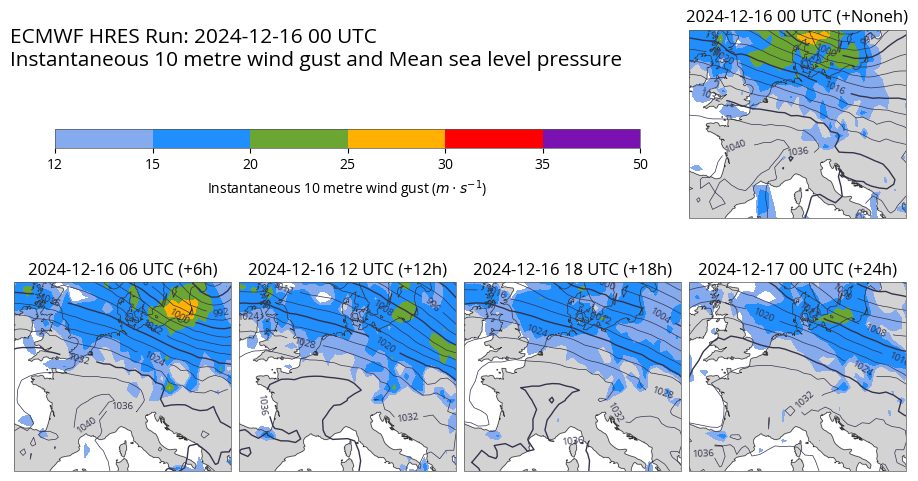

In [12]:
import matplotlib.pyplot as plt

chart = earthkit.maps.Chart(domain=[-5, 23, 40, 58], rows=3, columns=4)

gust_style = earthkit.maps.Style(
    colors=["#85AAEE", "#208EFC", "#6CA632", "#FFB000", "#FF0000", "#7A11B1"],
    levels=[12, 15, 20, 25, 30, 35, 50],
    units="m s-1",
)

chart.add_subplot(row=0, column=3)
for i in range(4):
    chart.add_subplot(row=1+i//4, column=i%4)

chart.plot(data.sel(shortName="i10fg"), style=gust_style)
chart.plot(data.sel(shortName="msl"), units="hPa")

chart.land(color="lightgrey")
chart.coastlines()

ax = plt.axes((0.05, 0.8, 0.65, 0.025))
chart.legend(ax=ax)

chart.subplot_titles("{time:%Y-%m-%d %H} UTC (+{lead_time}h)")
chart.title(
    "ECMWF HRES Run: {base_time:%Y-%m-%d %H} UTC\n{variable_name}",
    fontsize=15, horizontalalignment="left", x=0, y=0.96,
)

chart.show()